In [1]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
tqdm.pandas()

In [2]:
train_df = pd.read_csv('./dataset/mediaeval-2015-trainingset.txt', sep='\t', index_col=None)

# Exploration

In [3]:
train_df.columns

Index(['tweetId', 'tweetText', 'userId', 'imageId(s)', 'username', 'timestamp',
       'label'],
      dtype='object')

In [4]:
train_df['label'].value_counts()

fake     6742
real     4921
humor    2614
Name: label, dtype: int64

In [5]:
train_df.head()

tweetId                                          tweetText  \
0  263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1  262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2  262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3  262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4  263018881839411200  My fave place in the world #nyc #hurricane #sa...   

      userId      imageId(s)        username                       timestamp  \
0   21226711  sandyA_fake_46         iAnnieM  Mon Oct 29 22:34:01 +0000 2012   
1  192378571  sandyA_fake_09  CarlosVerareal  Mon Oct 29 19:11:23 +0000 2012   
2  132303095  sandyA_fake_09     LucasPalape  Mon Oct 29 18:11:08 +0000 2012   
3  241995902  sandyA_fake_29     Haaaaarryyy  Mon Oct 29 19:15:33 +0000 2012   
4  250315890  sandyA_fake_15  princess__natt  Mon Oct 29 20:46:02 +0000 2012   

  label  
0  fake  
1  fake  
2  fake  
3  fake  
4  fake

In [6]:
train_df.shape

(14277, 7)

In [7]:
len(train_df['tweetText'])-len(train_df['tweetText'].drop_duplicates())

1901

In [8]:
print(len(train_df['tweetText']))
print(len(train_df.drop_duplicates()))

14277
14276


In [9]:
import re
emoji_regex = re.compile("["
                         u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                         "]+", flags=re.UNICODE)
url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"

train_df['test'] = train_df['tweetText'].apply(lambda text: re.sub(emoji_regex, '', text))
train_df['test'] = train_df['test'].apply(lambda text: re.sub(url_regex, '', text))
print(len(train_df['test']))
print(len(train_df['test'].drop_duplicates()))

14277
11765


In [10]:
from langdetect import LangDetectException, detect
from nltk import TweetTokenizer
import re

tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
emoji_regex = re.compile("["
                         u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                         "]+", flags=re.UNICODE)

def count_emojis(text: str) -> int:
    return len(re.findall(emoji_regex, text))

def count_urls(text: str) -> int:
    return len(re.findall(url_regex, text))

def count_hashtags(text: str) -> int:
    return len([word for word in tokenizer.tokenize(text) if word[0] == '#'])

def detect_language(text: str) -> str:
    try:
        return detect(text)
    except LangDetectException:
        return 'N/A'

In [11]:
train_df['emojis'] = train_df['tweetText'].progress_apply(lambda text: count_emojis(text))
train_df['hashtags'] = train_df['tweetText'].progress_apply(lambda text: count_hashtags(text))
train_df['tweetLength'] = train_df['tweetText'].progress_apply(lambda text: len(text))
train_df['language'] = train_df['tweetText'].progress_apply(lambda text: detect_language(text))
train_df['label'] = train_df['label'].apply(lambda label: 'fake' if label == 'humor' else label)

train_df[['tweetId', 'tweetText', 'emojis', 'hashtags']].head(10)

100%|██████████| 14277/14277 [01:30<00:00, 157.41it/s]


tweetId                                          tweetText  \
0  263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1  262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2  262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3  262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4  263018881839411200  My fave place in the world #nyc #hurricane #sa...   
5  263364439582060545  42nd #time #square #NYC #subway #hurricane htt...   
6  262927032705490944  Just in time for #halloween a photo of #hurric...   
7  263321078884077568  Crazy pic of #Hurricane #Sandy prayers go out ...   
8  263111677485142017  #sandy #newyork #hurricane #statueofliberty #U...   
9  262977091983785985               #nyc #hurricane http://t.co/Gv3QxZlq   

   emojis  hashtags  
0       0         1  
1       0         0  
2       0         2  
3       0         2  
4       1         4  
5       0         5  
6       0         4  
7       0         2  
8       0         5  
9       0         2

In [12]:
fake_df = train_df[train_df['label'] == 'fake']
real_df = train_df[train_df['label'] == 'real']
print(f'Fake length = {fake_df.shape}')
print(f'Real length = {real_df.shape}')

Fake length = (9356, 12)
Real length = (4921, 12)


## Length of Tweets

<AxesSubplot: >

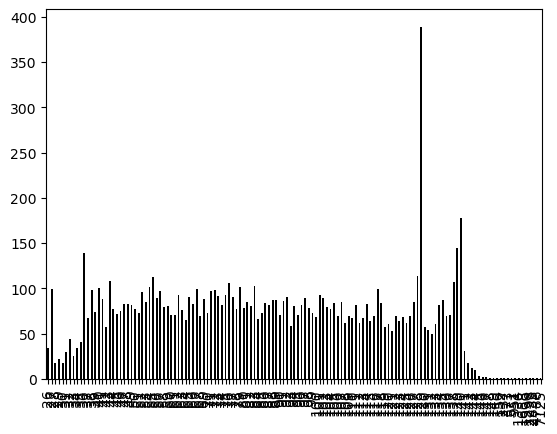

In [13]:
fake_df['tweetLength'].value_counts().sort_index().plot(kind='bar', color='black')

<AxesSubplot: >

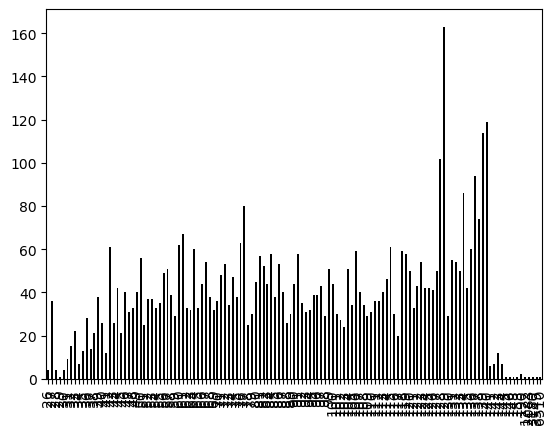

In [14]:
real_df['tweetLength'].value_counts().sort_index().plot(kind='bar', color='black')

## Number of Emojis

<AxesSubplot: >

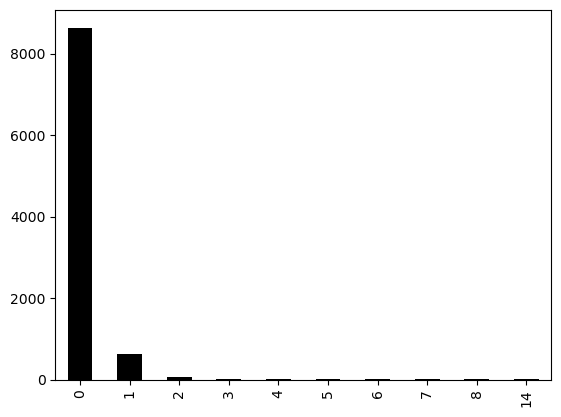

In [15]:
fake_df['emojis'].value_counts().sort_index().plot(kind='bar', color='black')

<AxesSubplot: >

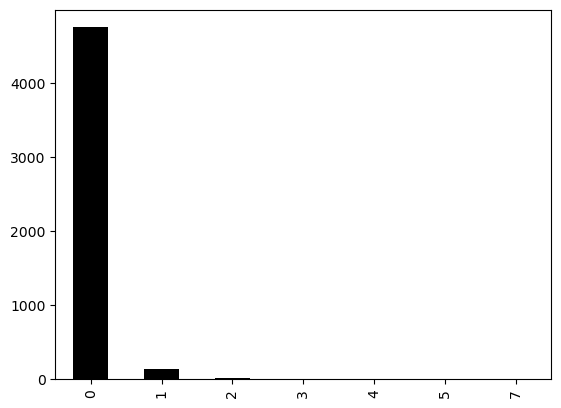

In [16]:
real_df['emojis'].value_counts().sort_index().plot(kind='bar', color='black')

## Number of Hashtags

<AxesSubplot: >

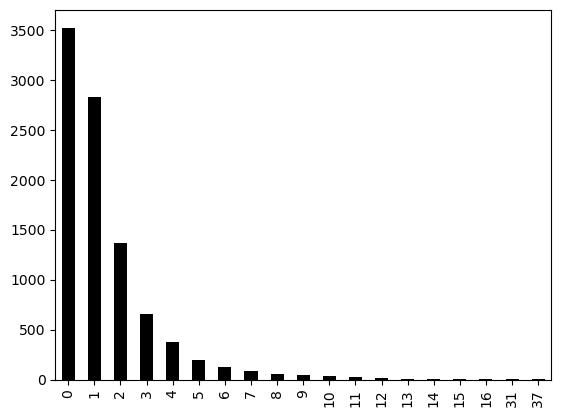

In [19]:
fake_df['hashtags'].value_counts().sort_index().plot(kind='bar', color='black')

<AxesSubplot: >

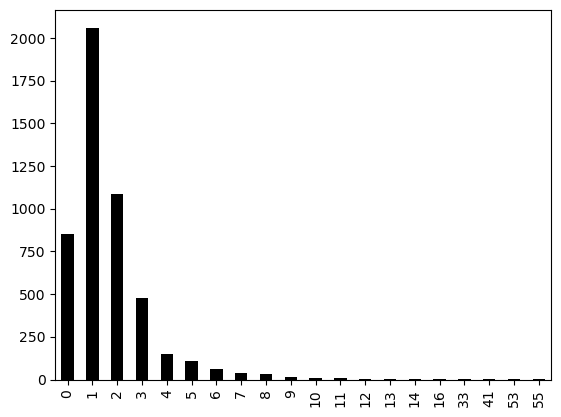

In [20]:
real_df['hashtags'].value_counts().sort_index().plot(kind='bar', color='black')

<AxesSubplot: title={'center': "Number of Hashtags in 'fake' tweets vs Occurrences"}>

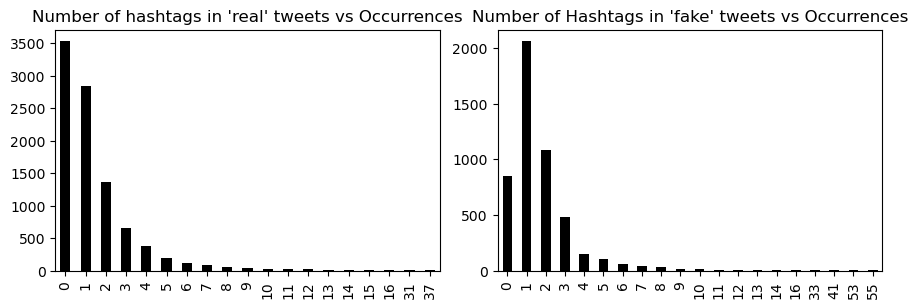

In [30]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
fig.tight_layout()

fake_df['hashtags'].value_counts().sort_index().plot(kind='bar', color='black', ax=axes[0], title="Number of hashtags in 'real' tweets vs Occurrences")
real_df['hashtags'].value_counts().sort_index().plot(kind='bar', color='black', ax=axes[1], title="Number of Hashtags in 'fake' tweets vs Occurrences")